In this notebook I will show how to obtain floor material features. The default model used for this was trained in Mexicali, so it is possible that it might not work so well in different contexts. 

In [1]:
import sys
sys.path.append("/Users/juanlegaria/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/CFC/alivestreets/alivestreets")
from alivestreets.features.floor_segmentation import FloorFeatureExtractor



Exported: data/network_4.geojson
393


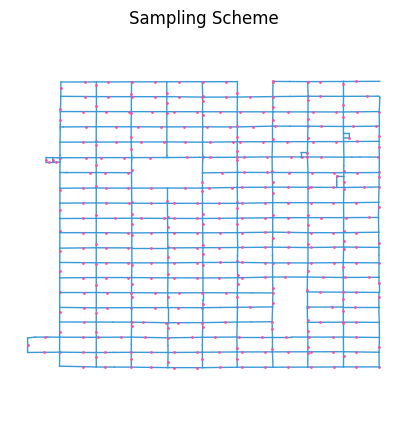

In [2]:
from alivestreets.network import network_retrieval
import os
import matplotlib.pyplot as plt

latitude = 32.6539470204236, 
longitude = -115.50050820067587
radius = 600

graph = network_retrieval.get_graph_from_point(latitude, longitude, radius)
network_path = "data/network_4.geojson"
network_retrieval.export_graph_geojson(graph, network_path)

from alivestreets.sampling.street_sampler import StreetSampler
street_sampler = StreetSampler(400)
street_sampler.open_streets("data/network_4.geojson")
street_sampler.sample_streets_no_intersections()
street_sampler.draw_sampling_scheme(width = 5, height = 5)

print(len(street_sampler.get_all_sampling_points()))


In [5]:
from alivestreets.streetview_collection.streetview_network_collection import StreetViewNetworkCollector
api_key = ""
#In this case i will simply obtain the sidewalk views.
network_image_collector = StreetViewNetworkCollector(
    "sidewalks",
    api_key
)

output_path_images = os.path.join(os.getcwd(), "data", "network_images_floor")


#point_dictionaries = network_image_collector.collect_street_sampler_images(
    #street_sampler,
    #output_path_images
#)

import json

with open(os.path.join(output_path_images,"point_dictionaries.jsonl"), "r") as f:
    point_dictionaries = [json.loads(line) for line in f.readlines()]

### Concrete index

Concrete index is defined as the area occupied by concrete over the total area of the image.

In [15]:
import cv2
from tqdm import tqdm 

floor_extractor = FloorFeatureExtractor()
floor_extractor.download_model()

concrete_index_list = []
for point_dict in tqdm(point_dictionaries):
    image_paths = point_dict["view_paths"]
    counter = 0
    concrete_index = 0
    for path in image_paths:
        img = cv2.imread(path)
        results = floor_extractor.compute(
            ["floor_concrete"], 
            img
        )
        concrete_index += results["floor_concrete"]["floor_concrete_index"]
        counter += 1
    concrete_index /= counter
    concrete_index_list.append(concrete_index)



Model downloaded


100%|██████████| 393/393 [06:21<00:00,  1.03it/s]


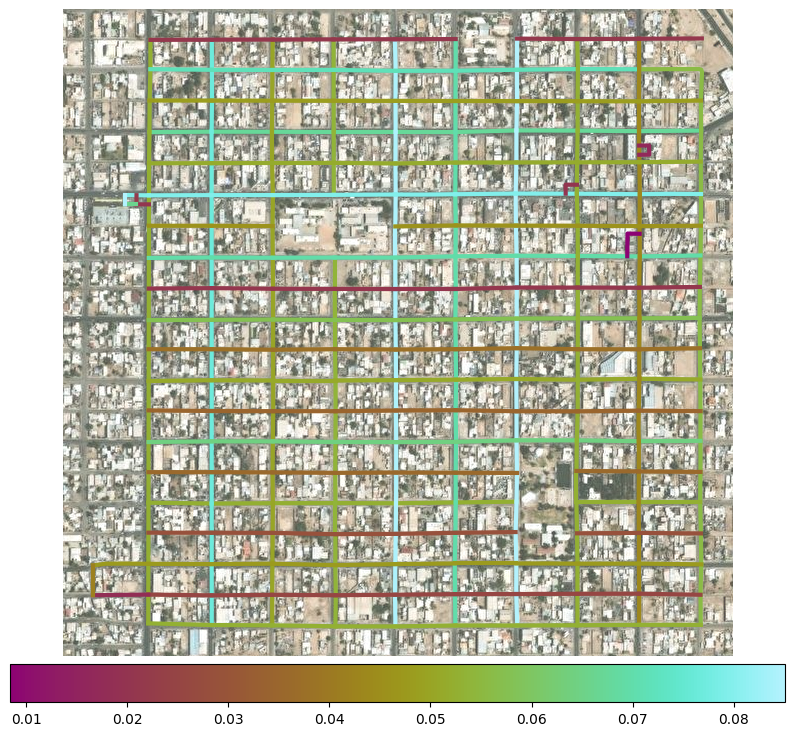

In [29]:
from alivestreets.visualization.map_visualizer import MapVisualizer
import cmcrameri.cm as cmc
street_sampler.tag_streets(
    "concrete_index",
    concrete_index_list,
    method = "mean"
)

map_visualizer = MapVisualizer()
map_visualizer.initialize_map()
map_visualizer.add_street_sampler(
    street_sampler,
    "concrete_index",
    "continuous",
    cmap = cmc.hawaii,
    edge_width = 3
)
map_visualizer.draw_networks(
    colorbar_orientation = "horizontal",
    min_percentile = 1, 
    max_percentile = 95
)

map_visualizer.add_basemap(
    alpha = 0.7, 
    zoom = "auto", 
    tile_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)

map_visualizer.finalize_map()


### Asphalt index

In [30]:
#Let's do something similar for asphalt.
asphalt_index_list = []
for point_dict in tqdm(point_dictionaries):
    image_paths = point_dict["view_paths"]
    counter = 0
    asphalt_index = 0
    for path in image_paths:
        img = cv2.imread(path)
        results = floor_extractor.compute(
            ["asphalt"], 
            img
        )
        asphalt_index += results["asphalt"]["asphalt_index"]
        counter += 1
    asphalt_index /= counter
    asphalt_index_list.append(asphalt_index)

100%|██████████| 393/393 [06:33<00:00,  1.00s/it]


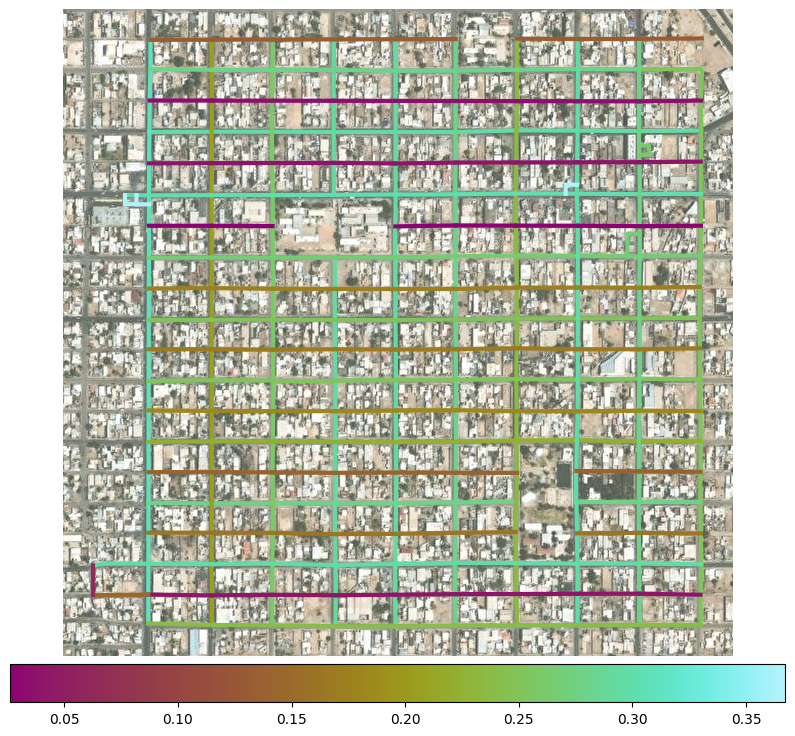

In [34]:
#Tag the streets with the asphalt index.
street_sampler.tag_streets(
    "asphalt_index",
    asphalt_index_list,
    method = "mean"
)

#Visualize the asphalt index.
map_visualizer = MapVisualizer()
map_visualizer.initialize_map()
map_visualizer.add_street_sampler(
    street_sampler,
    "asphalt_index",
    "continuous",
    cmap = cmc.hawaii,
    edge_width = 3
)
map_visualizer.draw_networks(
    colorbar_orientation = "horizontal",
    min_percentile = 1, 
    max_percentile = 90
)
map_visualizer.add_basemap(
    alpha = 0.7, 
    zoom = "auto", 
    tile_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)
map_visualizer.finalize_map()

### Dust index

In [35]:
#Now dust index
dust_index_list = []
for point_dict in tqdm(point_dictionaries):
    image_paths = point_dict["view_paths"]
    counter = 0
    dust_index = 0
    for path in image_paths:
        img = cv2.imread(path)
        results = floor_extractor.compute(
            ["dust"], 
            img
        )
        dust_index += results["dust"]["dust_index"]
        counter += 1
    dust_index /= counter
    dust_index_list.append(dust_index)

100%|██████████| 393/393 [06:46<00:00,  1.03s/it]


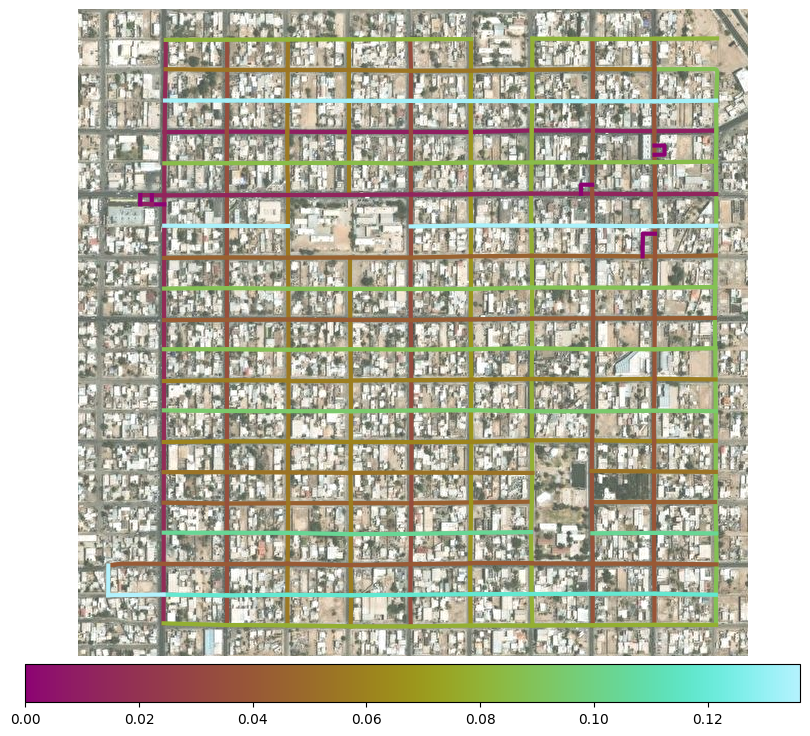

In [36]:
#Tag the streets.
street_sampler.tag_streets(
    "dust_index",
    dust_index_list,
    method = "mean"
)
#Visualize the dust index.
map_visualizer = MapVisualizer()
map_visualizer.initialize_map()
map_visualizer.add_street_sampler(
    street_sampler,
    "dust_index",
    "continuous",
    cmap = cmc.hawaii,
    edge_width = 3
)
map_visualizer.draw_networks(
    colorbar_orientation = "horizontal",
    min_percentile = 1, 
    max_percentile = 95
)
map_visualizer.add_basemap(
    alpha = 0.7, 
    zoom = "auto", 
    tile_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)
map_visualizer.finalize_map()

### Urban void counts

In [39]:
#Finally, urban void counts. 
#Here we need to define a custom operation 

urban_void_counter = lambda facade_calculator, image, classes, threshold: {
    floor_class: {
        f"{floor_class}_count": len(facade_calculator.get_masks(
            image, 
            class_name = floor_class)[0]),
        "confidences": facade_calculator.get_masks(
            image,
            class_name = floor_class)[1]
    }
    for floor_class in classes
}

urban_void_count_list = []
for point_dict in tqdm(point_dictionaries):
    image_paths = point_dict["view_paths"]
    urban_void_count = 0
    for path in image_paths:
        img = cv2.imread(path)
        results = floor_extractor.compute(
            ["urban_void"], 
            img,
            operation = urban_void_counter
        )
        urban_void_count += results["urban_void"]["urban_void_count"]
    urban_void_count_list.append(urban_void_count)



100%|██████████| 393/393 [13:14<00:00,  2.02s/it]


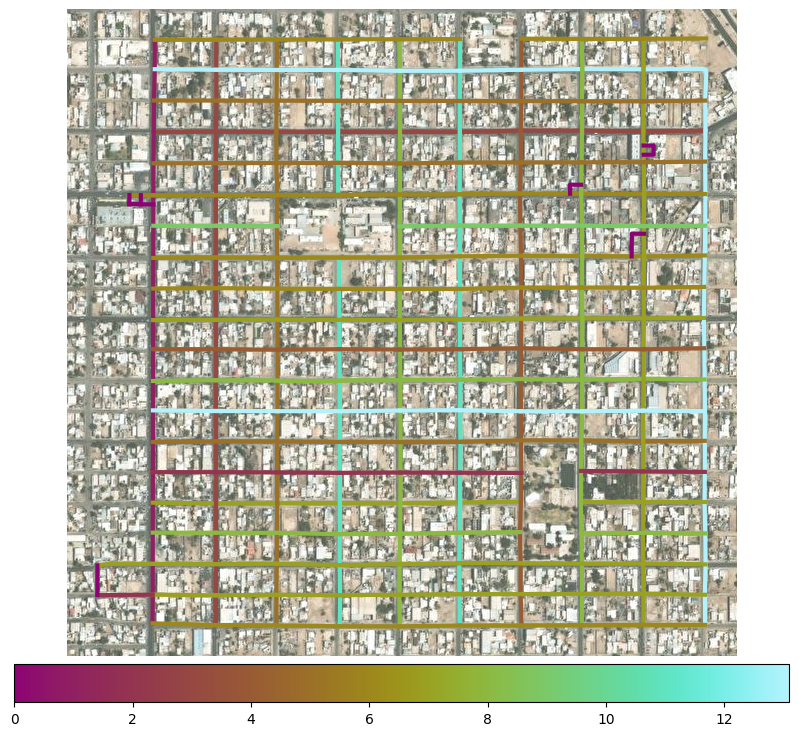

In [41]:
#Tag the streets with the urban void count.
street_sampler.tag_streets(
    "urban_void_count",
    urban_void_count_list,
    method = "sum"
)

#Visualize the urban void count.
map_visualizer = MapVisualizer()
map_visualizer.initialize_map()
map_visualizer.add_street_sampler(
    street_sampler,
    "urban_void_count",
    "continuous",
    cmap = cmc.hawaii,
    edge_width = 3
)
map_visualizer.draw_networks(
    colorbar_orientation = "horizontal",
    min_percentile = 1, 
    max_percentile = 95
)
map_visualizer.add_basemap(
    alpha = 0.7, 
    zoom = "auto", 
    tile_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
)
map_visualizer.finalize_map()